In [56]:
# 패키지 설지
!pip install google-analytics-data lets-plot seaborn



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: C:\Users\Aiden\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [47]:
from google.analytics.data_v1beta import BetaAnalyticsDataClient
from google.analytics.data_v1beta.types import DateRange, Dimension, Metric, RunReportRequest
from google.oauth2.service_account import Credentials

# Google Cloud Console에서 다운로드한 서비스 계정 키 경로
key_file_location = '../Quickstart-93ce48675b3f.json'

# 인증 설정
credentials = Credentials.from_service_account_file(key_file_location)
client = BetaAnalyticsDataClient(credentials=credentials)

# Google Analytics Property ID 설정
property_id = '356464508'

# 데이터 쿼리 설정
date_ranges = [DateRange(start_date='92daysAgo', end_date='today')]  # 원하는 기간 설정
metrics = [Metric(name='sessions')]  # 가져올 메트릭 설정
dimensions = [Dimension(name='date')]  # 가져올 디멘션 설정

# 데이터 쿼리 요청 객체 생성
request = RunReportRequest(
    property=f'properties/{property_id}',
    dimensions=dimensions,
    metrics=metrics,
    date_ranges=date_ranges
)

# 데이터 쿼리 실행
response = client.run_report(request)

# 결과 추출
rows = response.rows
for row in rows:
    print(f"Date: {row.dimension_values[0].value}, Sessions: {row.metric_values[0].value}")



Date: 20240507, Sessions: 77
Date: 20240625, Sessions: 65
Date: 20240429, Sessions: 59
Date: 20240430, Sessions: 42
Date: 20240523, Sessions: 35
Date: 20240424, Sessions: 23
Date: 20240503, Sessions: 22
Date: 20240626, Sessions: 22
Date: 20240501, Sessions: 20
Date: 20240508, Sessions: 20
Date: 20240510, Sessions: 16
Date: 20240620, Sessions: 14
Date: 20240524, Sessions: 13
Date: 20240618, Sessions: 13
Date: 20240624, Sessions: 12
Date: 20240518, Sessions: 11
Date: 20240721, Sessions: 11
Date: 20240423, Sessions: 10
Date: 20240505, Sessions: 9
Date: 20240509, Sessions: 9
Date: 20240517, Sessions: 9
Date: 20240528, Sessions: 9
Date: 20240511, Sessions: 8
Date: 20240512, Sessions: 8
Date: 20240522, Sessions: 8
Date: 20240527, Sessions: 8
Date: 20240425, Sessions: 7
Date: 20240513, Sessions: 7
Date: 20240604, Sessions: 7
Date: 20240704, Sessions: 7
Date: 20240427, Sessions: 6
Date: 20240520, Sessions: 6
Date: 20240525, Sessions: 6
Date: 20240529, Sessions: 6
Date: 20240621, Sessions: 6
Da

In [2]:
# EDA above data
import pandas as pd
import datetime

data = {
    'date': [datetime.datetime.strptime(row.dimension_values[0].value, '%Y%m%d') for row in rows],
    'sessions': [int(row.metric_values[0].value) for row in rows]
}

df = pd.DataFrame(data)
df = df.sort_values(by='date')
df

,date,sessions
47,2024-04-21,4
59,2024-04-22,3
17,2024-04-23,10
5,2024-04-24,23
26,2024-04-25,7
...,...,...
45,2024-07-18,5
66,2024-07-19,3
87,2024-07-20,1
16,2024-07-21,11


In [139]:
# Data 정보
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86 entries, 79 to 63
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      86 non-null     datetime64[ns]
 1   sessions  86 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.0 KB


In [140]:
# EDA 기초 통곗값
df.describe()


,date,sessions
count,86,86.000000
mean,2024-05-14 15:54:25.116279040,10.488372
min,2024-03-30 00:00:00,1.000000
25%,2024-04-23 06:00:00,3.250000
50%,2024-05-14 12:00:00,6.000000
75%,2024-06-04 18:00:00,12.750000
max,2024-06-28 00:00:00,77.000000
std,NaN,13.307003


<Axes: xlabel='date', ylabel='sessions'>

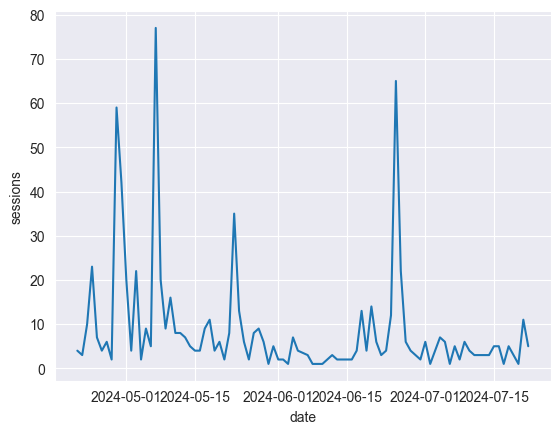

In [5]:
# make a regression above data

import seaborn as sns
import lets_plot as gg

sns.lineplot(data=df, x='date', y='sessions')



In [120]:
# plot with lets_plot
gg.ggplot(df) + gg.aes(x='date', y='sessions') + gg.geom_line()


<Axes: >

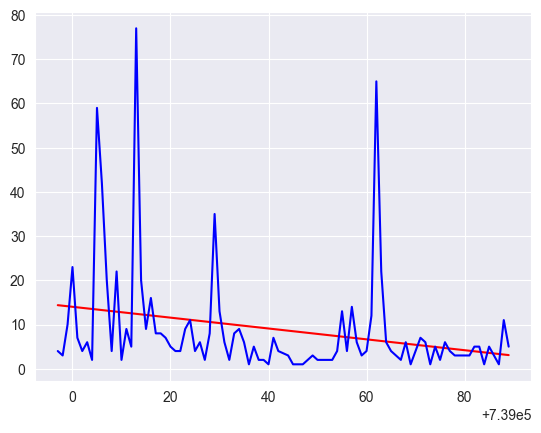

In [6]:
# forecast with linear regression
from sklearn.linear_model import LinearRegression
import numpy as np

# convert date to ordinal
df['date_ordinal'] = df['date'].apply(lambda x: x.toordinal())
X = df['date_ordinal'].values.reshape(-1, 1)
y = df['sessions'].values

model = LinearRegression()
model.fit(X, y)

# forecast
X_pred = np.arange(df['date_ordinal'].min(), df['date_ordinal'].max() + 1).reshape(-1, 1)
y_pred = model.predict(X_pred)

# plot
sns.lineplot(x=X_pred.flatten(), y=y_pred, color='red')
sns.lineplot(x=X.flatten(), y=y, color='blue')


<Axes: >

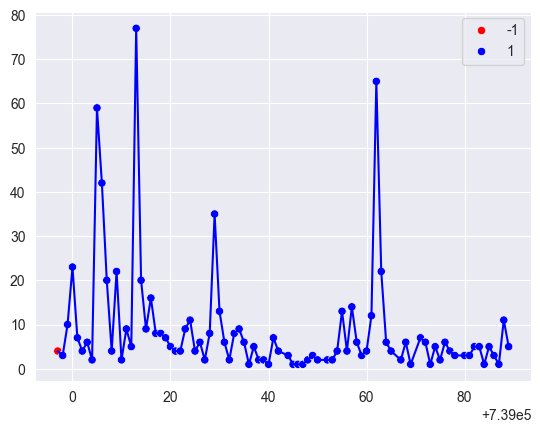

In [8]:
# anomaly detection
from sklearn.ensemble import IsolationForest

# convert date to ordinal
df['date_ordinal'] = df['date'].apply(lambda x: x.toordinal())
X = df['date_ordinal'].values.reshape(-1, 1)
y = df['sessions'].values

model = IsolationForest(contamination=0.01)
model.fit(X)

# forecast
y_pred = model.predict(X)

# plot. blue is normal, red is anomaly
sns.lineplot(x=X.flatten(), y=y, color='blue')
sns.scatterplot(x=X.flatten(), y=y, hue=y_pred, palette=['red', 'blue'])


In [136]:
# get cohort data from GA
from google.analytics.data_v1beta import BetaAnalyticsDataClient

# Google Cloud Console에서 다운로드한 서비스 계정 키 경로
key_file_location = '../Quickstart-93ce48675b3f.json'

# 인증 설정
credentials = Credentials.from_service_account_file(key_file_location)
client = BetaAnalyticsDataClient(credentials=credentials)

# Google Analytics Property ID 설정
property_id = '356464508'

# 데이터 쿼리 설정
date_ranges = [DateRange(start_date='92daysAgo', end_date='today')]  # 원하는 기간 설정
metrics = [Metric(name='sessions')]  # 가져올 메트릭 설정
dimensions = [Dimension(name='date'), Dimension(name='cohort')]  # 가져올 디멘션 설정

# InvalidArgument: 400 Cohort dimensions can only be used in requests with a CohortSpec.
dimensions = [Dimension(name='date'), Dimension(name='cohort')]  # 가져올 디멘션 설정

# 데이터 쿼리 요청 객체 생성
request = RunReportRequest(
    property=f'properties/{property_id}',
    dimensions=dimensions,
    metrics=metrics,
    date_ranges=date_ranges
)

# 데이터 쿼리 실행
response = client.run_report(request)

# 결과 추출
rows = response.rows
for row in rows:
    print(
        f"Date: {row.dimension_values[0].value}, Cohort: {row.dimension_values[1].value}, Sessions: {row.metric_values[0].value}")
    
    


InvalidArgument: 400 Cohort dimensions can only be used in requests with a CohortSpec.

In [17]:
# RFM 1
from google.analytics.data_v1beta import BetaAnalyticsDataClient
from google.analytics.data_v1beta.types import DateRange, Dimension, Metric, RunReportRequest
from google.oauth2.service_account import Credentials
from google.analytics.data import BetaAnalyticsDataClient
from google.analytics.data_v1beta.types import DateRange, Dimension, Metric, RunReportRequest
import pandas as pd
import datetime
from google.oauth2 import service_account


# Google Cloud Console에서 다운로드한 서비스 계정 키 경로
key_file_location = '../Quickstart-93ce48675b3f.json'

# 인증 설정
credentials = Credentials.from_service_account_file(key_file_location)
client = BetaAnalyticsDataClient(credentials=credentials)

# Google Analytics Property ID 설정
property_id = '356464508'


# 요청 생성
request = RunReportRequest(
    property=f'properties/{property_id}',  # GA4 속성 ID
    dimensions=[Dimension(name="userId")],
    metrics=[Metric(name="purchaseRevenue"), Metric(name="purchaseCount")],
    date_ranges=[DateRange(start_date="365daysAgo", end_date="today")],
)

# 보고서 실행
response = client.run_report(request)

# 응답 데이터프레임으로 변환
rows = []
for row in response.rows:
    rows.append({
        "userId": row.dimension_values[0].value,
        "purchaseRevenue": float(row.metric_values[0].value),
        "purchaseCount": int(row.metric_values[1].value),
    })

df = pd.DataFrame(rows)

InvalidArgument: 400 Did you mean itemId? Field userId is not a valid dimension. For a list of valid dimensions and metrics, see https://developers.google.com/analytics/devguides/reporting/data/v1/api-schema 

In [19]:
from google.analytics.data import BetaAnalyticsDataClient
from google.analytics.data_v1beta.types import DateRange, Dimension, Metric, RunReportRequest
import pandas as pd
import datetime

# 서비스 계정 인증 설정
from google.oauth2 import service_account

# 서비스 계정 JSON 파일 경로
key_path = "../Quickstart-93ce48675b3f.json"

# 인증 객체 생성
credentials = service_account.Credentials.from_service_account_file(key_path)

# GA4 API 클라이언트 생성
client = BetaAnalyticsDataClient(credentials=credentials)

property_id = '356464508'

# 요청 생성
request = RunReportRequest(
    property=f'properties/{property_id}',  # GA4 속성 ID
    dimensions=[Dimension(name="itemId")],
    metrics=[Metric(name="itemRevenue"), Metric(name="itemPurchaseQuantity")],
    date_ranges=[DateRange(start_date="365daysAgo", end_date="today")],
)

# 보고서 실행
response = client.run_report(request)

# 응답 데이터프레임으로 변환
rows = []
for row in response.rows:
    rows.append({
        "itemId": row.dimension_values[0].value,
        "itemRevenue": float(row.metric_values[0].value),
        "itemPurchaseQuantity": int(row.metric_values[1].value),
    })

df = pd.DataFrame(rows)

# 예제 데이터를 위한 변환
df['lastPurchaseDate'] = datetime.datetime.now() - pd.to_timedelta(df['itemPurchaseQuantity'], unit='D')

# RFM 분석을 위한 데이터프레임 생성
rfm_df = df.groupby('itemId').agg({
    'lastPurchaseDate': lambda x: (datetime.datetime.now() - x.max()).days,
    'itemPurchaseQuantity': 'sum',
    'itemRevenue': 'sum'
}).reset_index()

# 컬럼 이름 변경
rfm_df.columns = ['Item ID', 'Recency', 'Frequency', 'Monetary']

# RFM 점수 계산
rfm_df['R'] = pd.qcut(rfm_df['Recency'], 4, labels=False)
rfm_df['F'] = pd.qcut(rfm_df['Frequency'], 4, labels=False)
rfm_df['M'] = pd.qcut(rfm_df['Monetary'], 4, labels=False)

# 최종 RFM 점수
rfm_df['RFM_Score'] = rfm_df['R'].astype(str) + rfm_df['F'].astype(str) + rfm_df['M'].astype(str)

# RFM 점수별 고객 분류
rfm_df['RFM_Level'] = rfm_df['RFM_Score'].apply(lambda x: 'Top' if x >= '333' else 'Medium' if x >= '222' else 'Low')



KeyError: 'itemPurchaseQuantity'

In [20]:
from google.analytics.data import BetaAnalyticsDataClient
from google.analytics.data_v1beta.types import DateRange, Dimension, Metric, RunReportRequest
import pandas as pd
import datetime

# 서비스 계정 인증 설정
from google.oauth2 import service_account
# 서비스 계정 JSON 파일 경로
key_path = "../Quickstart-93ce48675b3f.json"
# 인증 객체 생성
credentials = service_account.Credentials.from_service_account_file(key_path)
# GA4 API 클라이언트 생성
client = BetaAnalyticsDataClient(credentials=credentials)
property_id = '356464508'

# 요청 생성
request = RunReportRequest(
    property=f'properties/{property_id}',  # GA4 속성 ID
    dimensions=[Dimension(name="itemName")],  # 'itemName'을 사용
    metrics=[Metric(name="itemRevenue"), Metric(name="itemQuantity")],  # 유효한 메트릭 사용
    date_ranges=[DateRange(start_date="365daysAgo", end_date="today")],
)

# 보고서 실행
response = client.run_report(request)

# 응답 데이터프레임으로 변환
rows = []
for row in response.rows:
    rows.append({
        "itemName": row.dimension_values[0].value,
        "itemRevenue": float(row.metric_values[0].value),
        "itemQuantity": int(row.metric_values[1].value),
    })

df = pd.DataFrame(rows)

# 예제 데이터를 위한 변환
df['lastPurchaseDate'] = datetime.datetime.now() - pd.to_timedelta(df['itemQuantity'], unit='D')

# RFM 분석을 위한 데이터프레임 생성
rfm_df = df.groupby('itemName').agg({
    'lastPurchaseDate': lambda x: (datetime.datetime.now() - x.max()).days,
    'itemQuantity': 'sum',
    'itemRevenue': 'sum'
}).reset_index()

# 컬럼 이름 변경
rfm_df.columns = ['Item Name', 'Recency', 'Frequency', 'Monetary']

# RFM 점수 계산
rfm_df['R'] = pd.qcut(rfm_df['Recency'], 4, labels=False)
rfm_df['F'] = pd.qcut(rfm_df['Frequency'], 4, labels=False)
rfm_df['M'] = pd.qcut(rfm_df['Monetary'], 4, labels=False)

# 최종 RFM 점수
rfm_df['RFM_Score'] = rfm_df['R'].astype(str) + rfm_df['F'].astype(str) + rfm_df['M'].astype(str)

# RFM 점수별 고객 분류
rfm_df['RFM_Level'] = rfm_df['RFM_Score'].apply(lambda x: 'Top' if x >= '333' else 'Medium' if x >= '222' else 'Low')

# 결과 출력
import ace_tools as tools; tools.display_dataframe_to_user(name="RFM Analysis Results", dataframe=rfm_df)

rfm_df.head()


InvalidArgument: 400 Did you mean itemRevenue? Field itemQuantity is not a valid metric.  For a list of valid dimensions and metrics, see https://developers.google.com/analytics/devguides/reporting/data/v1/api-schema 

ValueError: Unknown format code 'd' for object of type 'float'

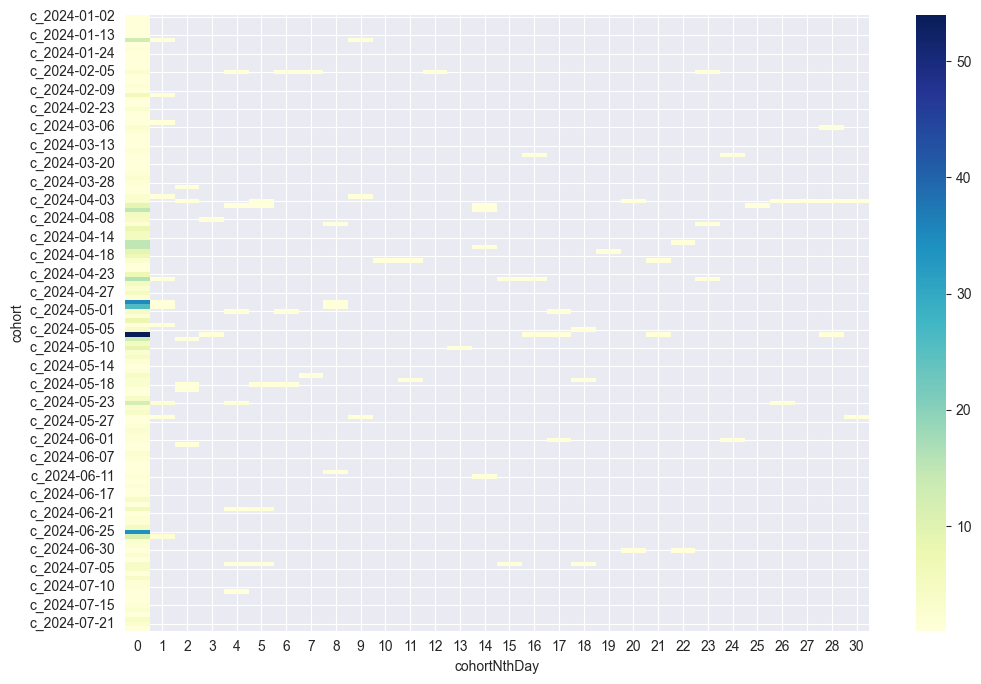

In [41]:
# 히트맵 그리기
from google.analytics.data_v1beta import BetaAnalyticsDataClient
from google.analytics.data_v1beta.types import DateRange, Dimension, Metric, RunReportRequest, CohortSpec, Cohort, CohortsRange
from google.oauth2 import service_account
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 서비스 계정 JSON 파일 경로 설정
key_path = "../Quickstart-93ce48675b3f.json"
property_id = '356464508'

# 인증 객체 생성
credentials = service_account.Credentials.from_service_account_file(key_path)

# GA4 API 클라이언트 생성
client = BetaAnalyticsDataClient(credentials=credentials)

cohorts = []
# add 365 days cohort from 2024-01-01
start_date = datetime.datetime.strptime("2024-01-01", "%Y-%m-%d")
for i in range(1, 366):
    the_date = start_date + datetime.timedelta(days=i)
    cohort = Cohort(
        dimension="firstSessionDate",
        name=f"c_{the_date.strftime('%Y-%m-%d')}",
        date_range=DateRange(start_date=the_date.strftime('%Y-%m-%d'), end_date=the_date.strftime('%Y-%m-%d'))
    )
    cohorts.append(cohort)

# 코호트 사양 설정
cohort_spec = CohortSpec(
    cohorts=cohorts,
    cohorts_range=CohortsRange(
        granularity="DAILY",
        start_offset=0,
        end_offset=30
    )
)

# 리포트 요청 설정
request = RunReportRequest(
    property=f"properties/{property_id}",
    dimensions=[
        Dimension(name="cohort"),
        Dimension(name="cohortNthDay")
    ],
    metrics=[Metric(name="activeUsers")],
    cohort_spec=cohort_spec
)

# 데이터 가져오기
response = client.run_report(request)

# 응답 데이터를 DataFrame으로 변환
data = []
for row in response.rows:
    row_data = {
        "cohort": row.dimension_values[0].value,
        "cohortNthDay": int(row.dimension_values[1].value),
        "activeUsers": int(row.metric_values[0].value)
    }
    data.append(row_data)

df = pd.DataFrame(data)

# 코호트 분석 데이터 변환
cohort_pivot = df.pivot(index='cohort', columns='cohortNthDay', values='activeUsers')
# 
# # 코호트 분석 결과 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(cohort_pivot, annot=True, fmt="d", cmap="YlGnBu")
plt.title('User Cohort Analysis')
plt.xlabel('Day')
plt.ylabel('Cohort (First Session Date)')
plt.show()


In [46]:
from google.analytics.data_v1beta import BetaAnalyticsDataClient
from google.analytics.data_v1beta.types import DateRange, Dimension, Metric, RunReportRequest, CohortSpec, Cohort, CohortsRange
from google.oauth2 import service_account
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 서비스 계정 JSON 파일 경로 설정
key_path = "../Quickstart-93ce48675b3f.json"
property_id = '356464508'

# 인증 객체 생성
credentials = service_account.Credentials.from_service_account_file(key_path)

# GA4 API 클라이언트 생성
client = BetaAnalyticsDataClient(credentials=credentials)

cohorts = []
# add 365 days cohort from 2024-01-01
start_date = datetime.datetime.strptime("2024-01-01", "%Y-%m-%d")
for i in range(1, 366):
    the_date = start_date + datetime.timedelta(days=i)
    cohort = Cohort(
        dimension="firstSessionDate",
        name=f"c_{the_date.strftime('%Y-%m-%d')}",
        date_range=DateRange(start_date=the_date.strftime('%Y-%m-%d'), end_date=the_date.strftime('%Y-%m-%d'))
    )
    cohorts.append(cohort)

# 코호트 사양 설정
cohort_spec = CohortSpec(
    cohorts=cohorts,
    cohorts_range=CohortsRange(
        granularity="DAILY",
        start_offset=0,
        end_offset=30
    )
)

# 리포트 요청 설정
request = RunReportRequest(
    property=f"properties/{property_id}",
    dimensions=[
        Dimension(name="cohort"),
        Dimension(name="cohortNthDay")
    ],
    metrics=[Metric(name="activeUsers")],
    cohort_spec=cohort_spec
)

# 데이터 가져오기
response = client.run_report(request)

# 응답 데이터를 DataFrame으로 변환
data = []
for row in response.rows:
    row_data = {
        "cohort": row.dimension_values[0].value,
        "cohortNthDay": int(row.dimension_values[1].value),
        "activeUsers": int(row.metric_values[0].value)
    }
    data.append(row_data)

df = pd.DataFrame(data)

# save to csv
df.to_csv('cohort.csv', index=False)
